In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [23]:
df = pd.read_csv("test_hoechstgan_o66b9xsh.csv")
df.describe()

,CD3+ cells,CD3 real MIR,CD3 fake MIR,CD3 relative MIR,CD8+ cells,CD8 real MIR,CD8 fake MIR,CD8 relative MIR
count,4880.000000,4801.000000,4801.000000,4800.000000,4880.000000,4081.000000,4.080000e+03,4.080000e+03
mean,4.979098,19.344376,172.198787,5.947626,3.273975,8.037556,9.167574e+03,1.055236e+03
std,4.108985,129.526402,3695.644798,51.031686,3.364046,11.148661,4.145524e+05,5.736590e+04
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00
25%,2.000000,8.751435,6.279818,0.576507,1.000000,4.531718,3.821172e+00,6.880176e-01
50%,4.000000,12.654789,11.660271,0.975565,2.000000,6.173827,6.587222e+00,1.126390e+00
75%,7.000000,19.643873,30.673176,2.153991,5.000000,8.803667,1.464419e+01,2.145638e+00
max,36.000000,8865.395508,248261.530000,2788.954346,28.000000,482.335327,2.578360e+07,3.651772e+06


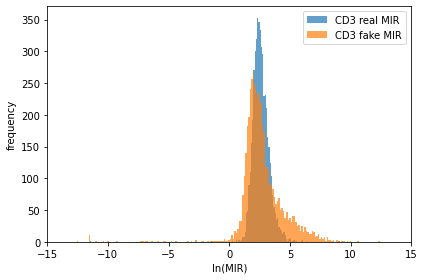

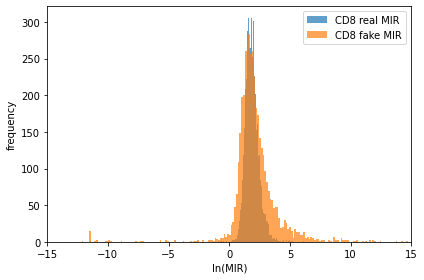

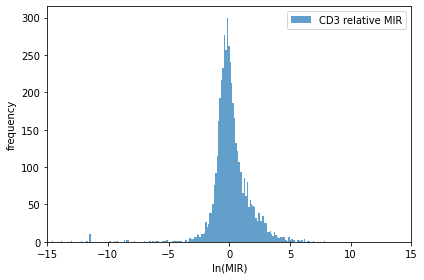

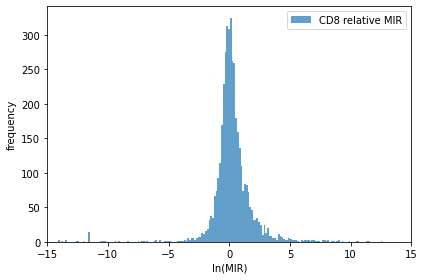

In [48]:
def plot_hist(col, color=None):
    x = np.array(df[col])
    x = x[~np.isnan(x)]
    x[x == 0] = 1e-5
    x = np.log(x)
    plt.hist(x, bins=200, alpha=.7, label=col, color=color)
    plt.xlim(-15, 15)
    plt.xlabel("ln(MIR)")
    plt.ylabel("frequency")
    plt.tight_layout()

plt.figure()
plot_hist("CD3 real MIR")
plot_hist("CD3 fake MIR")
plt.legend()
plt.savefig("mir_real_fake_cd3.png")

plt.figure()
plot_hist("CD8 real MIR")
plot_hist("CD8 fake MIR")
plt.legend()
plt.savefig("mir_real_fake_cd8.png")

plt.figure()
plot_hist("CD3 relative MIR")
plt.legend()
plt.savefig("mir_relative_cd3.png")

plt.figure()
plot_hist("CD8 relative MIR")
plt.legend()
plt.savefig("mir_relative_cd8.png")